# Analysing the calibration of the BirdMAE model on BirdSet

In [36]:
# Load predictions from each test set by looping over all folders in /workspace/logs/predictions/convnext_bs and load the .pkl files

# load data in dict form: data[<dataset_name>] = (predictions, targets, metadata)
import os
import torch
from matplotlib import pyplot as plt
from uncertainbird.utils.misc import load_dump

data = {}

log_dir = "/workspace/logs/predictions/birdmae"
dataset_names = sorted(
    [d for d in os.listdir(log_dir) if os.path.isdir(os.path.join(log_dir, d))]
)

# colormap without red (tab10 index 3 is red)
colors = plt.cm.tab10
skip_index = 3
available_indices = [i for i in range(colors.N) if i != skip_index]
dataset_colors = {}

for i, ds in enumerate(dataset_names):
    data[ds] = {}
    color_idx = available_indices[i % len(available_indices)]
    dataset_colors[ds] = colors(color_idx)

    ds_path = os.path.join(log_dir, ds)
    pkl_files = [f for f in os.listdir(ds_path) if f.endswith(".pkl")]
    if not pkl_files:
        continue
    # pick most recent file
    pkl_files.sort(
        key=lambda f: os.path.getmtime(os.path.join(ds_path, f)), reverse=True
    )
    file_path = os.path.join(ds_path, pkl_files[0])
    preds, t, metadata = load_dump(file_path)
    data[ds]["predictions"] = preds
    data[ds]["targets"] = t.int()
    data[ds]["metadata"] = metadata
    data[ds]["color"] = dataset_colors[ds]

# concatenate
valid_keys = [
    k
    for k, v in data.items()
    if isinstance(v, dict)
    and "predictions" in v
    and "targets" in v
    and isinstance(v["predictions"], torch.Tensor)
    and isinstance(v["targets"], torch.Tensor)
]

if not valid_keys:
    raise ValueError("No datasets with both 'predictions' and 'targets' present.")

# optionally report skipped datasets
skipped = [k for k in data.keys() if k not in valid_keys]
if skipped:
    print("Skipped datasets (missing predictions/targets):", skipped)

predictions = torch.cat([data[k]["predictions"] for k in valid_keys], dim=0)
targets = torch.cat([data[k]["targets"] for k in valid_keys], dim=0)

data = {k: data[k] for k in valid_keys}

predictions.shape, targets.shape

Loaded data with 12000 samples
Predictions shape: torch.Size([12000, 9736])
Targets shape: torch.Size([12000, 9736])
Model info: {'class_name': 'MultilabelModule', 'task': 'multilabel', 'num_classes': None}
Loaded data with 539 samples
Predictions shape: torch.Size([539, 9736])
Targets shape: torch.Size([539, 9736])
Model info: {'class_name': 'MultilabelModule', 'task': 'multilabel', 'num_classes': None}
Loaded data with 24480 samples
Predictions shape: torch.Size([24480, 9736])
Targets shape: torch.Size([24480, 9736])
Model info: {'class_name': 'MultilabelModule', 'task': 'multilabel', 'num_classes': None}
Loaded data with 15120 samples
Predictions shape: torch.Size([15120, 9736])
Targets shape: torch.Size([15120, 9736])
Model info: {'class_name': 'MultilabelModule', 'task': 'multilabel', 'num_classes': None}
Loaded data with 4560 samples
Predictions shape: torch.Size([4560, 9736])
Targets shape: torch.Size([4560, 9736])
Model info: {'class_name': 'MultilabelModule', 'task': 'multilab

(torch.Size([322292, 9736]), torch.Size([322292, 9736]))

In [37]:
data["HSN"].keys()

dict_keys(['predictions', 'targets', 'metadata', 'color'])

## Global - all labels incl. non present target labels

In [38]:
from uncertainbird.utils.plotting import print_metrics

# metrics = print_metrics(predictions, targets)

In [39]:
# reliability diagram
from uncertainbird.utils.plotting import plot_reliability_diagram

# plot_reliability_diagram(
#     predictions,
#     targets,
#     n_bins=10,
#     title=f"Reliability Diagram - ConvNeXt_BS on BirdSet | ECE weighted = {metrics['ece_weighted']*100:.2f}%",
# )

## Globael - only classes present in the target labels

```python

In [40]:
# how many classes are represented by atleast one sample in the targets?
print("Number of classes in targets:", targets.sum(dim=0).gt(0).sum().item())
# how many classes are represented by atleast 5 samples in the targets?
print(
    "Number of classes with atleast 5 samples in targets:",
    targets.sum(dim=0).ge(5).sum().item(),
)

Number of classes in targets: 411
Number of classes with atleast 5 samples in targets: 372


In [41]:
# select only target classes
predictions_targetclasses = predictions[:, targets.sum(dim=0).gt(0)]
targets_targetclasses = targets[:, targets.sum(dim=0).gt(0)]

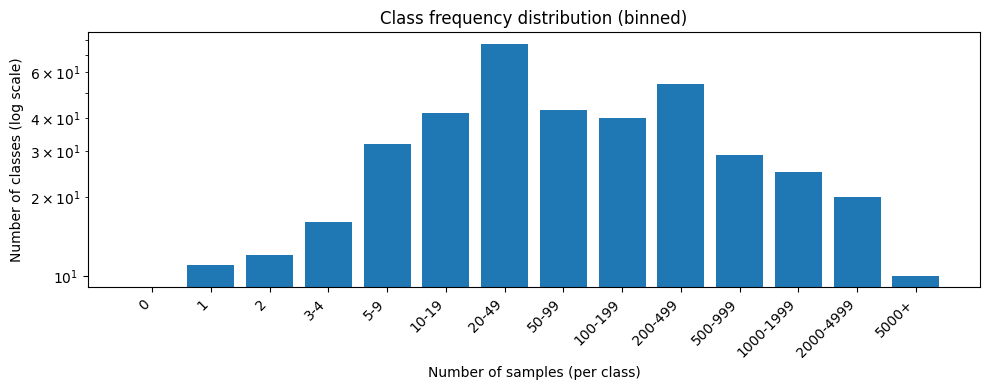

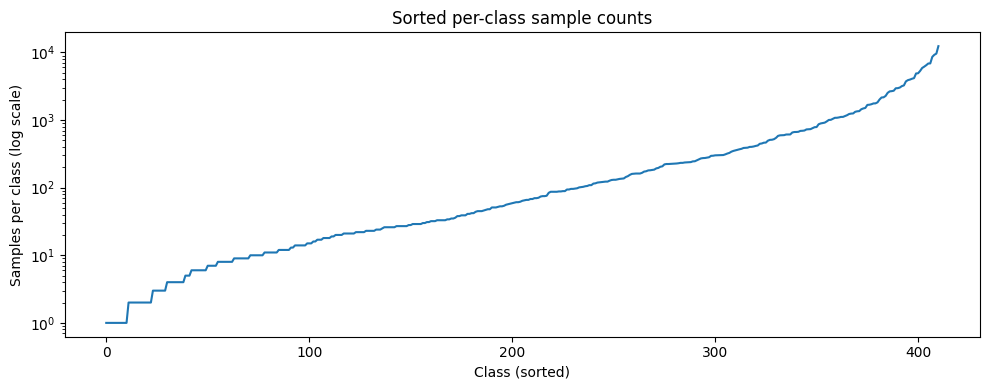

In [42]:
from uncertainbird.utils.plotting import plot_class_frequency

plot_class_frequency(targets_targetclasses)

In [43]:
from uncertainbird.utils.plotting import print_metrics

metrics_targetclasses = print_metrics(predictions_targetclasses, targets_targetclasses)

Accuracy: tensor(0.9985)
cmAP: tensor(0.2549)
Precision: tensor(0.3916)
Recall: tensor(0.1854)
F1 Score: tensor(0.2017)
AUROC: tensor(0.8881)
ECE: tensor(0.1774)
ECE Weighted: tensor(0.1818)
ECE Top-3: tensor(0.1658)
ECE Top-5: tensor(0.1773)
ECE Top-10: tensor(0.1818)
ECE Top-21: tensor(0.1876)
Miscalibration Score (MCS): tensor(0.1777)
ECE Under-confidence: tensor(0.0020)
ECE Over-confidence: tensor(0.1798)


<Axes: title={'center': 'Reliability Diagram - BirdMAE on BirdSet`s target classes | ECE weighted = 18.18%'}, xlabel='Mean Predicted Probability', ylabel='Fraction of Positives'>

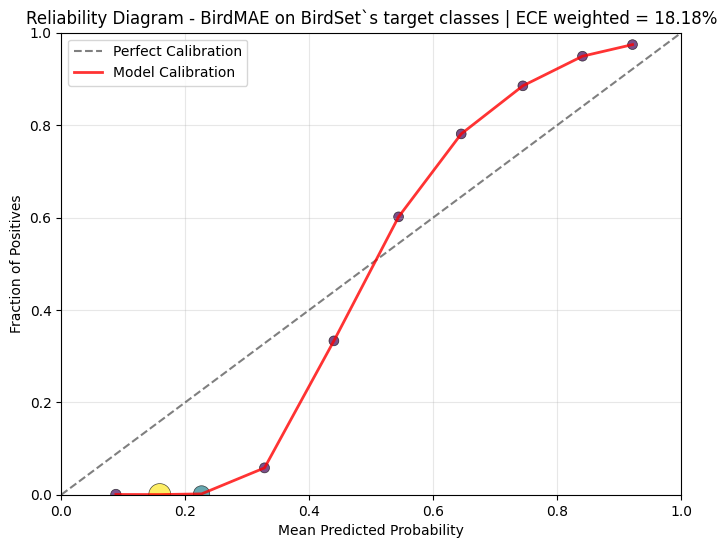

In [53]:
# reliability diagram
from uncertainbird.utils.plotting import plot_reliability_diagram

plot_reliability_diagram(
    predictions_targetclasses,
    targets_targetclasses,
    n_bins=10,
    title=f"Reliability Diagram - BirdMAE on BirdSet`s target classes | ECE weighted = {metrics_targetclasses['ece_weighted']*100:.2f}%",
)

## Class-wise Calibration Plots

In [45]:
# only select classes with target labels
for key in list(data.keys()):
    # keep the dict structure; only replace the predictions/targets tensors
    preds = data[key]["predictions"][:, targets.sum(dim=0).gt(0)]
    tars = data[key]["targets"][:, targets.sum(dim=0).gt(0)]
    data[key]["predictions"] = preds
    data[key]["targets"] = tars
    # metadata and color remain unchanged

In [46]:
# compute metrics
for key in data:
    print("Computing metrics for", key)
    preds = data[key]["predictions"]
    tar = data[key]["targets"]
    data[key]["metrics"] = print_metrics(preds, tar)

Computing metrics for HSN


/workspace/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)  # noqa: B028
/workspace/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Accuracy: tensor(0.9988)
cmAP: tensor(0.4628)
Precision: tensor(0.0286)
Recall: tensor(0.0097)
F1 Score: tensor(0.0123)
AUROC: tensor(0.0443)
ECE: tensor(0.1890)
ECE Weighted: tensor(0.1521)
ECE Top-3: tensor(0.1511)
ECE Top-5: tensor(0.1583)
ECE Top-10: tensor(0.1876)
ECE Top-21: tensor(0.1955)
Miscalibration Score (MCS): tensor(0.0897)
ECE Under-confidence: tensor(0.0312)
ECE Over-confidence: tensor(0.1209)
Computing metrics for NBP
Accuracy: tensor(0.9969)
cmAP: tensor(0.6242)
Precision: tensor(0.0981)
Recall: tensor(0.0381)
F1 Score: tensor(0.0508)
AUROC: tensor(0.1138)
ECE: tensor(0.1811)
ECE Weighted: tensor(0.1931)
ECE Top-3: tensor(0.1841)
ECE Top-5: tensor(0.1850)
ECE Top-10: tensor(0.1824)
ECE Top-21: tensor(0.1891)
Miscalibration Score (MCS): tensor(0.1786)
ECE Under-confidence: tensor(0.0072)
ECE Over-confidence: tensor(0.1858)
Computing metrics for NES
Accuracy: tensor(0.9990)
cmAP: tensor(0.3526)
Precision: tensor(0.0947)
Recall: tensor(0.0496)
F1 Score: tensor(0.0561)
AU

Accuracy: tensor(0.9991)
cmAP: tensor(0.3528)
Precision: tensor(0.1025)
Recall: tensor(0.0515)
F1 Score: tensor(0.0550)
AUROC: tensor(0.1811)
ECE: tensor(0.1777)
ECE Weighted: tensor(0.1958)
ECE Top-3: tensor(0.1862)
ECE Top-5: tensor(0.1876)
ECE Top-10: tensor(0.1970)
ECE Top-21: tensor(0.1999)
Miscalibration Score (MCS): tensor(0.1877)
ECE Under-confidence: tensor(0.0040)
ECE Over-confidence: tensor(0.1918)
Computing metrics for UHH
Accuracy: tensor(0.9975)
cmAP: tensor(0.2229)
Precision: tensor(0.0185)
Recall: tensor(0.0043)
F1 Score: tensor(0.0052)
AUROC: tensor(0.0464)
ECE: tensor(0.1727)
ECE Weighted: tensor(0.1511)
ECE Top-3: tensor(0.1667)
ECE Top-5: tensor(0.1462)
ECE Top-10: tensor(0.1433)
ECE Top-21: tensor(0.1494)
Miscalibration Score (MCS): tensor(0.0183)
ECE Under-confidence: tensor(0.0664)
ECE Over-confidence: tensor(0.0847)


### Reliability Diagram
```

#### Combined

<Axes: title={'center': 'Combined Reliability Diagram - ConvNeXt_BS on BirdSet'}, xlabel='Mean Predicted Probability', ylabel='Fraction of Positives'>

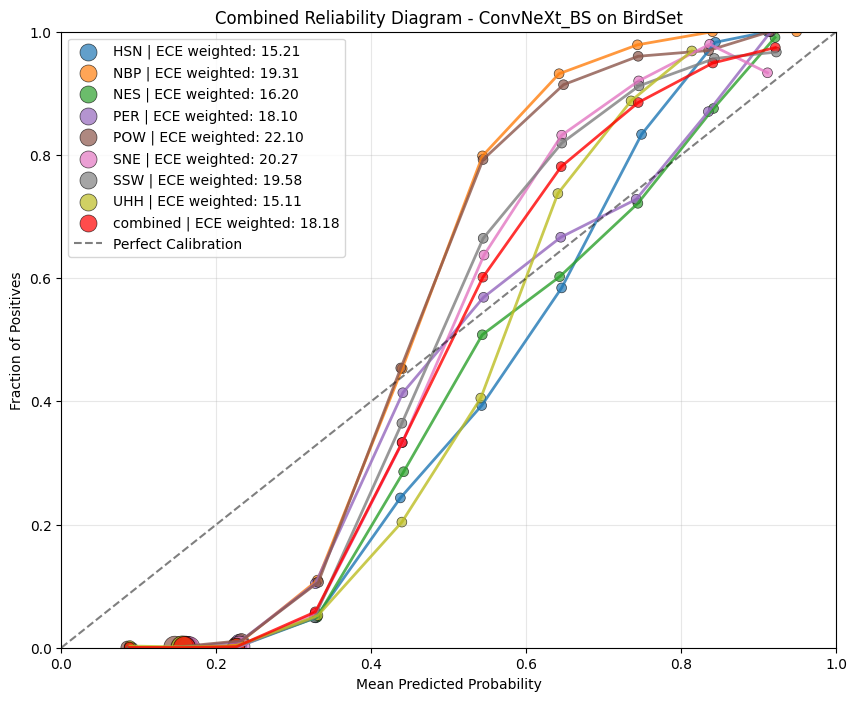

In [47]:
from uncertainbird.utils.plotting import plot_combined_reliability_diagram

# add average / combined data of all datasets
data["combined"] = {
    "predictions": predictions_targetclasses,
    "targets": targets_targetclasses,
    "metadata": None,
    "metrics": metrics_targetclasses,
    "color": "red",  # color for combined plot
}

plot_combined_reliability_diagram(
    data, n_bins=10, title="Combined Reliability Diagram - ConvNeXt_BS on BirdSet"
)

#### Per class

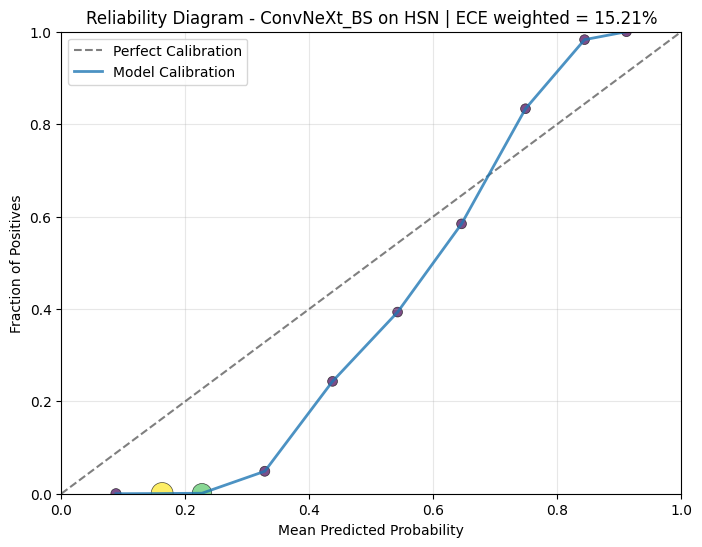

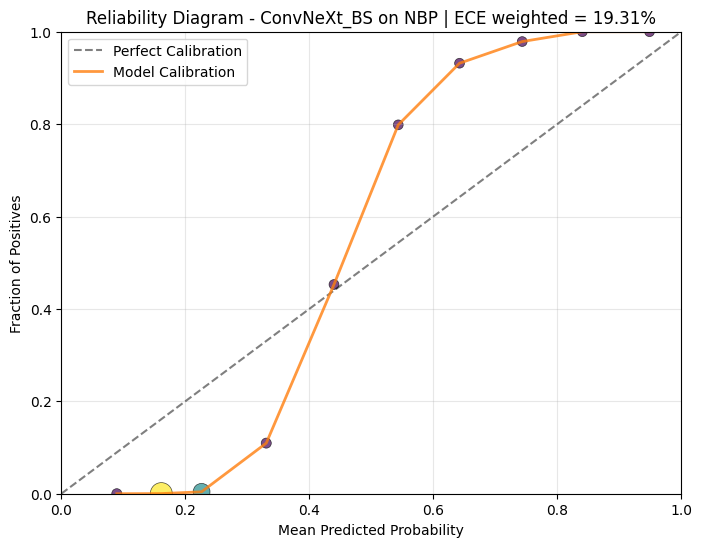

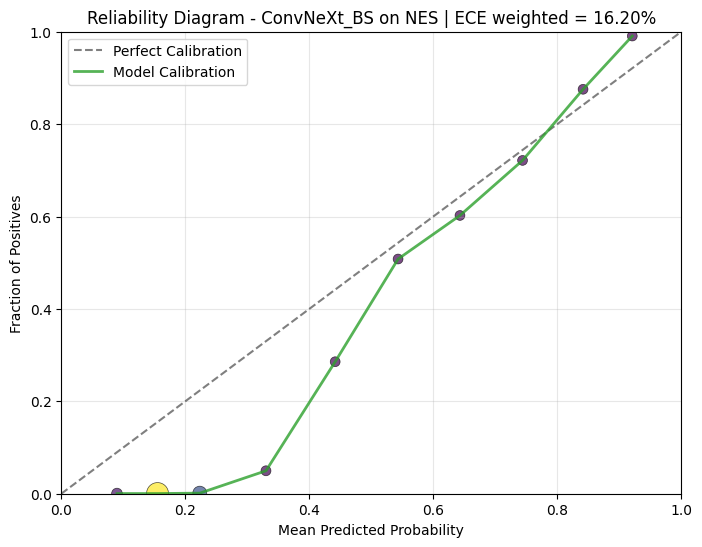

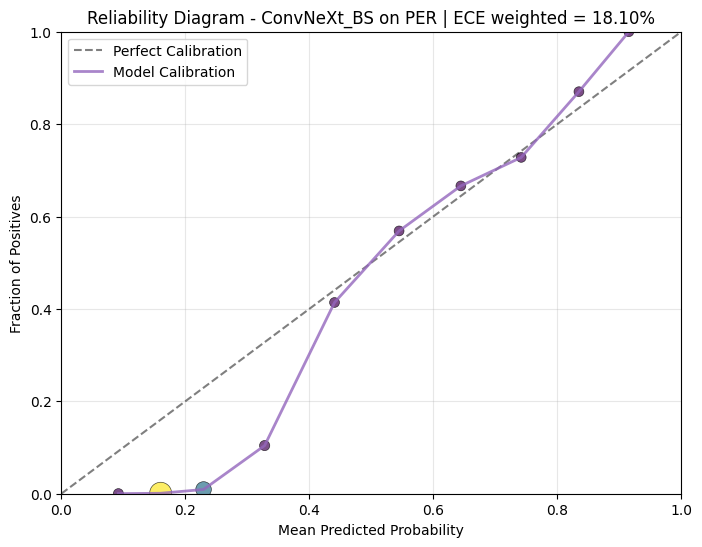

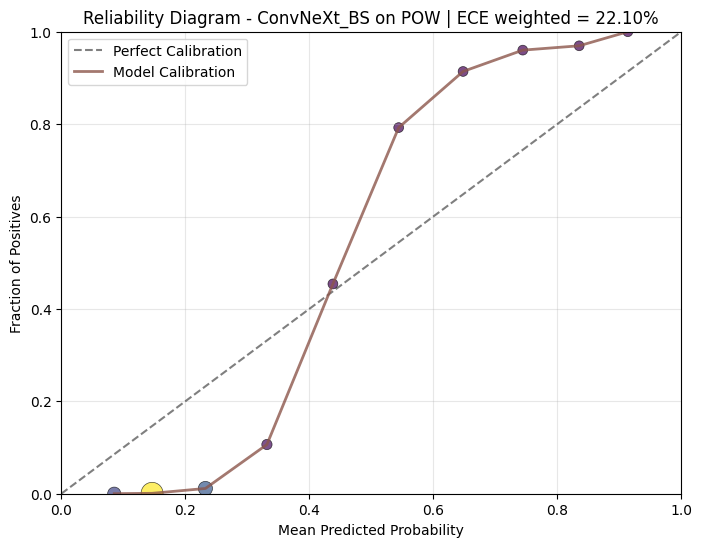

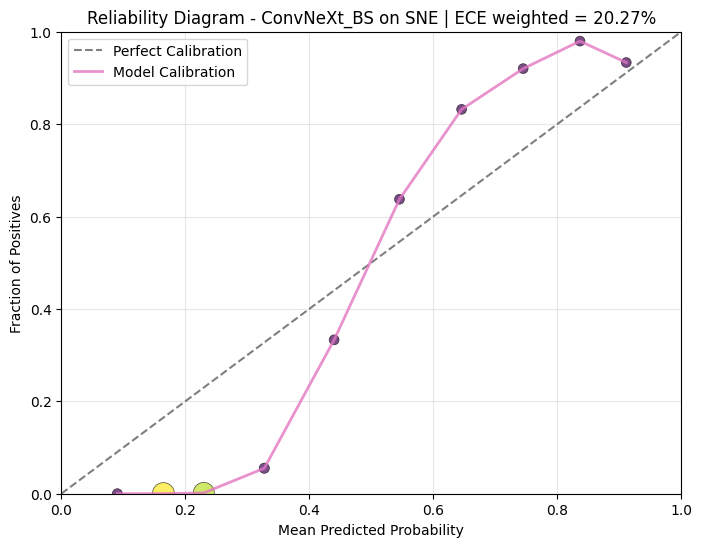

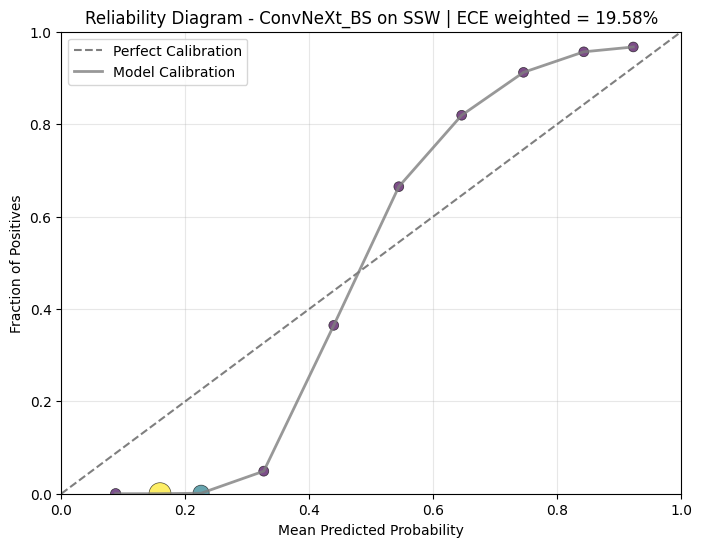

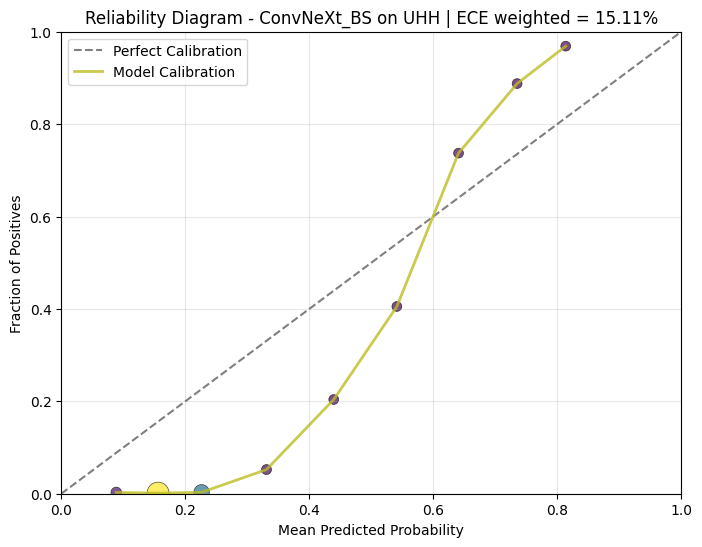

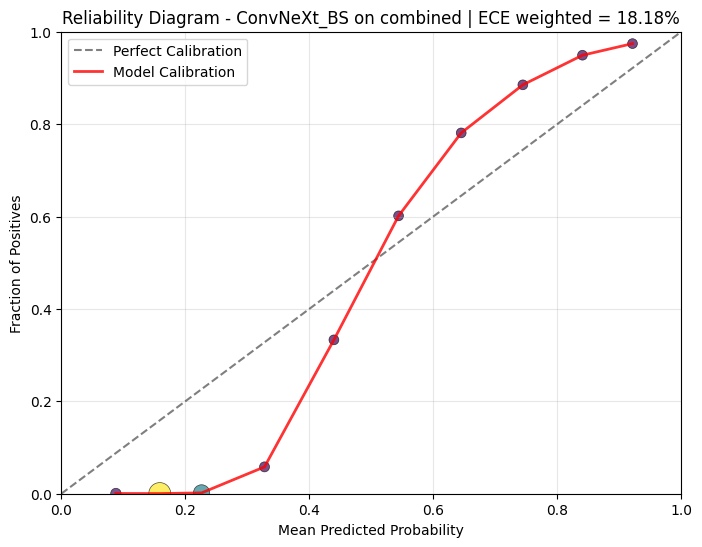

In [48]:
for key in data:
    plot_reliability_diagram(
        data[key]["predictions"],
        data[key]["targets"],
        n_bins=10,
        title=f"Reliability Diagram - ConvNeXt_BS on {key} | ECE weighted = {data[key]['metrics']['ece_weighted']*100:.2f}%",
        color=data[key].get("color", "red"),
    )

In [49]:
from uncertainbird.utils.misc import class_wise_statistics

preds = predictions_targetclasses.float()
tar = targets_targetclasses.int()

class_stats = class_wise_statistics(preds, tar, n_bins=10)

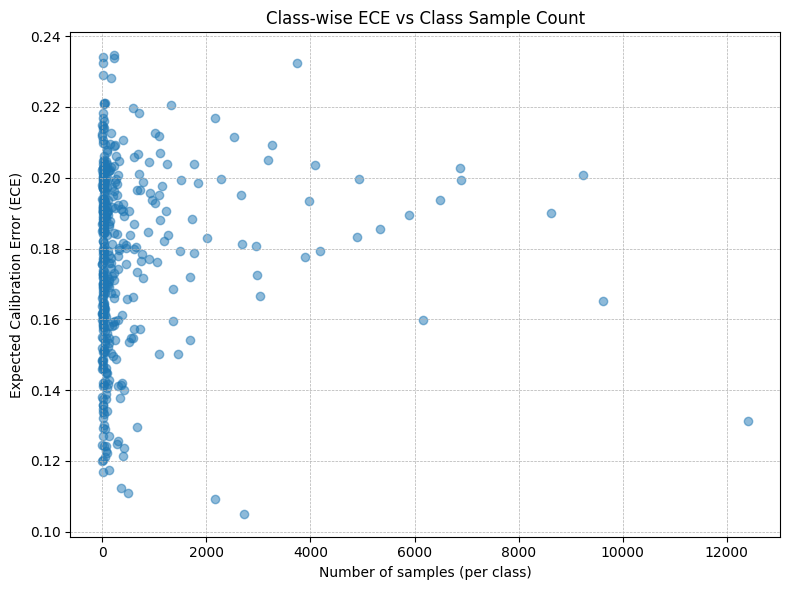

In [50]:
# plot ece vs class sample count
plt.figure(figsize=(8, 6))
plt.scatter(class_stats["positive_samples"], class_stats["ece"], alpha=0.5)
plt.xlabel("Number of samples (per class)")
plt.ylabel("Expected Calibration Error (ECE)")
plt.title("Class-wise ECE vs Class Sample Count")
plt.grid(True, ls="--", lw=0.5)
plt.tight_layout()
plt.show()

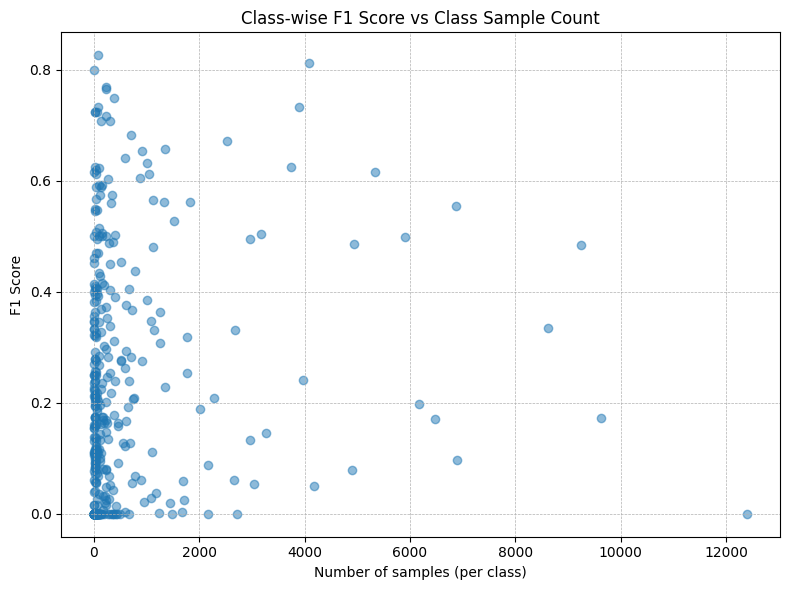

In [51]:
# f1 vs class sample count
plt.figure(figsize=(8, 6))
plt.scatter(class_stats["positive_samples"], class_stats["f1_score"], alpha=0.5)
plt.xlabel("Number of samples (per class)")
plt.ylabel("F1 Score")
plt.title("Class-wise F1 Score vs Class Sample Count")
plt.grid(True, ls="--", lw=0.5)
plt.tight_layout()

In [52]:
# print cmAP for each dataset in the format "Dataset: <name>, cmAP: <value>"
print("cmAP per dataset:")
for key in data:
    print(f"Dataset: {key}, cmAP: {data[key]['metrics']['cmAP']*100:.2f}")

print("ECE for each dataset:")
for key in data:
    print(f"Dataset: {key}, ece: {data[key]['metrics']['ece_weighted']*100:.2f}")
print("MCS for each dataset:")
for key in data:
    print(f"Dataset: {key}, mcs: {data[key]['metrics']['mcs']*100:.2f}")
print("Under confidence score for each dataset:")
for key in data:
    print(f"Dataset: {key}, mcs: {data[key]['metrics']['ece_under']*100:.2f}")
print("Over confidence score for each dataset:")
for key in data:
    print(f"Dataset: {key}, mcs: {data[key]['metrics']['ece_over']*100:.2f}")

cmAP per dataset:
Dataset: HSN, cmAP: 46.28
Dataset: NBP, cmAP: 62.42
Dataset: NES, cmAP: 35.26
Dataset: PER, cmAP: 25.26
Dataset: POW, cmAP: 39.55
Dataset: SNE, cmAP: 30.54
Dataset: SSW, cmAP: 35.28
Dataset: UHH, cmAP: 22.29
Dataset: combined, cmAP: 25.49
ECE for each dataset:
Dataset: HSN, ece: 15.21
Dataset: NBP, ece: 19.31
Dataset: NES, ece: 16.20
Dataset: PER, ece: 18.10
Dataset: POW, ece: 22.10
Dataset: SNE, ece: 20.27
Dataset: SSW, ece: 19.58
Dataset: UHH, ece: 15.11
Dataset: combined, ece: 18.18
MCS for each dataset:
Dataset: HSN, mcs: 8.97
Dataset: NBP, mcs: 17.86
Dataset: NES, mcs: 15.49
Dataset: PER, mcs: 12.10
Dataset: POW, mcs: -2.72
Dataset: SNE, mcs: 15.62
Dataset: SSW, mcs: 18.77
Dataset: UHH, mcs: 1.83
Dataset: combined, mcs: 17.77
Under confidence score for each dataset:
Dataset: HSN, mcs: 3.12
Dataset: NBP, mcs: 0.72
Dataset: NES, mcs: 0.35
Dataset: PER, mcs: 3.00
Dataset: POW, mcs: 12.41
Dataset: SNE, mcs: 2.32
Dataset: SSW, mcs: 0.40
Dataset: UHH, mcs: 6.64
Dataset